In [47]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates



# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [48]:
session = fastf1.get_session(2023,10,'R')
session.load()

core           INFO 	Loading data for British Grand Prix - Race [v2.3.1]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df

### Pre defined

In [49]:
compound_color = {'HARD': 'F0F0EC', 
                  'INTERMEDIATE': '43B02A', 
                  'MEDIUM': 'FFD12E', 
                  'SOFT': 'DA291C', 
                  'TEST-UNKNOWN': '434649', 
                  'UNKNOWN': '00FFFF', 
                  'WET': '0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']

In [50]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [51]:
def max_lap(laps):
    grouped = laps.groupby("Driver")
    count_values = grouped['LapNumber'].count()
    return count_values.max()

In [52]:
laps = session.laps
drivers = session.drivers[:10]
all_laps = laps
all_laps['LapStartTimeS'] = all_laps["LapStartTime"].dt.total_seconds()
all_laps['DeltaTime'] = 0

In [53]:
# laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
# laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")

In [54]:
delta_time = all_laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapStartTimeS","DeltaTime"]]
for i in drivers:
    a = delta_time.loc[delta_time["DriverNumber"] == i,["LapStartTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == '1',["LapStartTimeS"]].reset_index()
    length = len(delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"])
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = a.loc[:, "LapStartTimeS"].values[:length]

### Gap to race winner graph

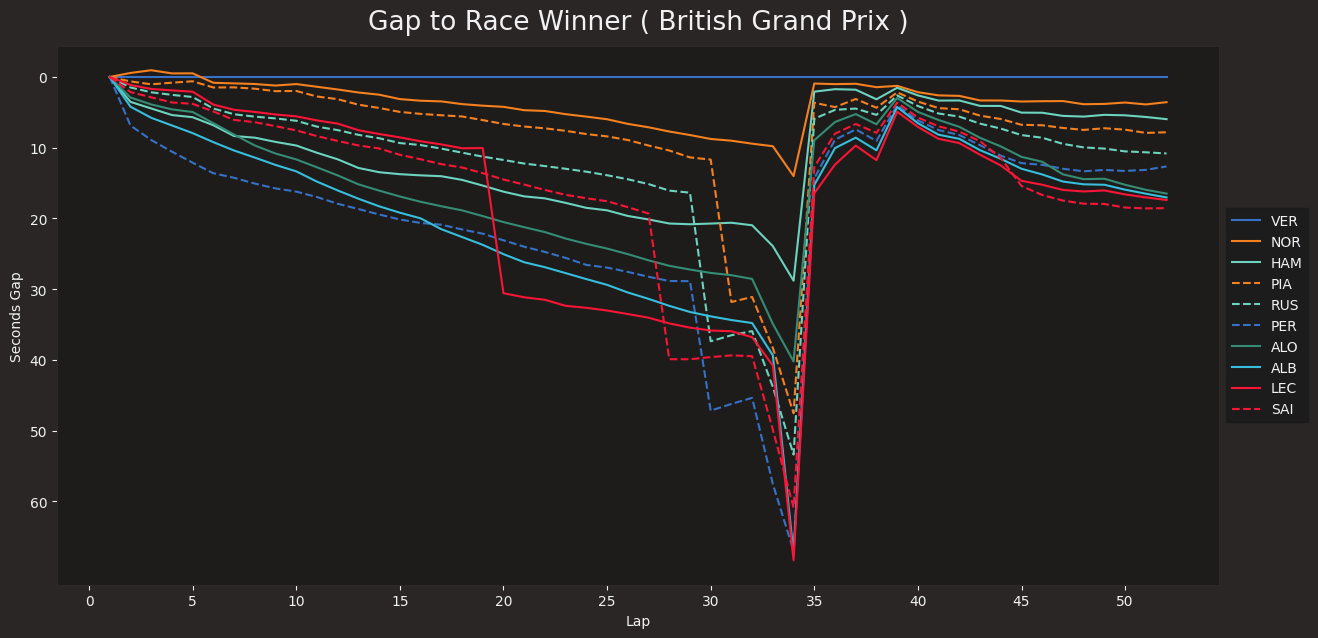

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
color_picked = []
max_gap = int(delta_time["DeltaTime"].max())
for i in drivers:
    x = delta_time.loc[delta_time["DriverNumber"]==i,["LapNumber"]]
    y = delta_time.loc[delta_time["DriverNumber"]==i,["DeltaTime"]]
    
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = session.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.plot(x, y, color="#"+team_color, linestyle='dashed', label=driver_name)
    else:    
        plt.plot(x, y, color="#"+team_color, linestyle='solid', label=driver_name)
        color_picked.append(team_color)

# Customize the plot
plt.title('Gap to Race Winner ( '+session.event["EventName"]+' )')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
plt.xticks(range(0, max_lap(laps), 5))
plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

# Add legend
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


### tires Strategy

In [56]:
drivers = session.drivers
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

We need to find the stint length and compound used
for every stint by every driver.
We do this by first grouping the laps by the driver,
the stint number, and the compound.
And then counting the number of laps in each group.



In [69]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.rename(columns={"LapNumber": "StintLength"})

The number in the LapNumber column now stands for the number of observations
in that group aka the stint length.



Now we can plot the strategies for each driver



In [58]:
# driver_stints = stints.loc[stints["Driver"] == 'VER']
# driver_stints.loc[driver_stints["Stint"]==1,"Stint"] = 2
# driver_stints

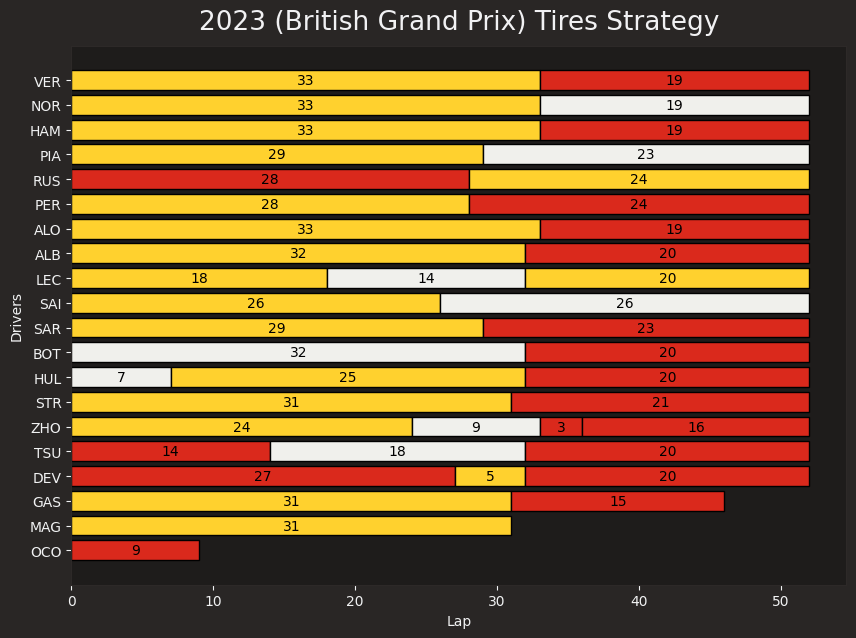

In [59]:
fig, ax = plt.subplots(figsize=(10, 7))

for driver in drivers_abr:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color='#'+compound_color[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        # Add the value over the bar
        plt.text(
            x=previous_stint_end + row["StintLength"] / 2,
            y=driver,
            s=str(row["StintLength"]),
            ha='center',
            va='center',
            color='black'  # Set text color to black
        )

        previous_stint_end += row["StintLength"]

# Customize the plot
plt.title('2023 (' + session.event["EventName"] + ') Tires Strategy')
plt.xlabel('Lap')
plt.ylabel('Drivers')
# plt.xticks(range(0, max_lap(laps), 5))
# plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

plt.show()


### Position on race

In [60]:
drivers = session.drivers

In [61]:
# position_drivers = laps.loc[laps["LapNumber"] == 2,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
# position_drivers["Position"] = list(range(1, 21))

In [62]:
first_lap = session.results
first_lap.loc[first_lap["GridPosition"] == 0,["GridPosition"]] = 20


In [63]:
first_lap = session.results[["DriverNumber","GridPosition"]].sort_values(by='GridPosition')
first_lap["Position"] = list(range(1, 21))

In [64]:
position_drivers = pd.merge( laps.loc[laps["LapNumber"] == 1,["DriverNumber","Driver","LapNumber","LapStartTime"]].reset_index(drop = True),first_lap[["DriverNumber","Position"]], on='DriverNumber', how='inner').sort_values(by = 'Position')

In [65]:
position_drivers_add = laps.loc[laps["LapNumber"] == 2,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
position_drivers_add["Position"] = list(range(1, 21))
position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)
for i in range(3,max_lap(laps)+1):
    position_drivers_add = laps.loc[laps["LapNumber"] == i,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
    position_drivers_add["Position"] = list(range(1, len(position_drivers_add)+1))
    position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)

In [66]:
drivers_abr = position_drivers.loc[position_drivers["LapNumber"]== 1,"Driver"].values

In [67]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

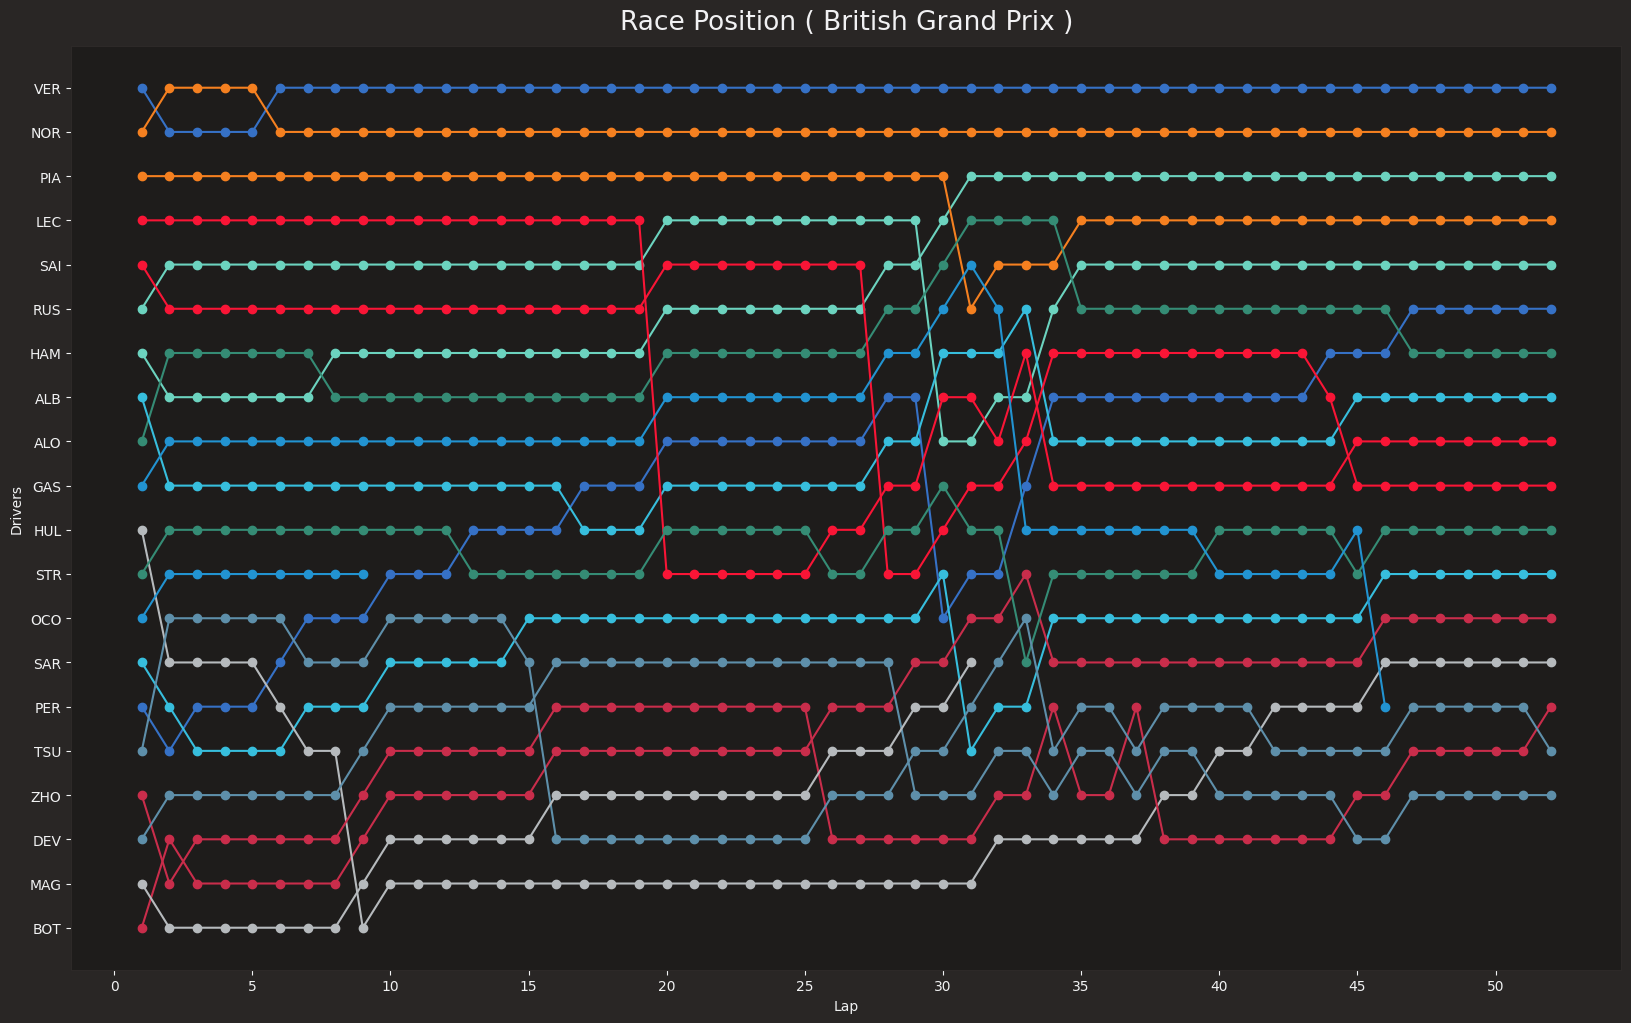

In [68]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 12))

# Plot each line with dots using a loop
for i in drivers:
    ax.plot(position_drivers.loc[position_drivers["DriverNumber"]== i,["LapNumber"]], position_drivers.loc[position_drivers["DriverNumber"]== i,["Position"]] 
            , marker='o', linestyle='-', color = "#"+session.get_driver(i)["TeamColor"] ,label=position_drivers.loc[(position_drivers["DriverNumber"]== i)&(position_drivers["LapNumber"]== 1),["Driver"]])

plt.title('Race Position ( '+session.event["EventName"]+' )')
plt.xlabel('Lap')
plt.ylabel('Drivers')
plt.xticks(range(0, max_lap(laps), 5))
plt.yticks(range(1, len(drivers) + 1),drivers_abr)
plt.gca().invert_yaxis()


# Add a legend
# ax.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()